<a href="https://colab.research.google.com/github/beyzoskaya/PyTorch_deepLearning/blob/main/CIFAR10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
from torch._C import TracingState
train_set = torchvision.datasets.CIFAR10(root="./data",
                                         train=True,
                                         download=True,
                                         transform=transform)
test_set = torchvision.datasets.CIFAR10(root="./data",
                                        train=False,
                                        download=True,
                                        transform=transform)

100%|██████████| 170498071/170498071 [00:10<00:00, 15869889.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
len(train_set), len(test_set)

(50000, 10000)

In [8]:
train_set, test_set

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [25]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [26]:
class_names = train_set.classes
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

In [27]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [28]:
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [30]:
img, label = next(iter(train_dataloader))
print(f"Shape for image: {img.shape}")
print(f"Shape for label: {label.shape}")

Shape for image: torch.Size([32, 3, 32, 32])
Shape for label: torch.Size([32])


In [18]:
from typing import Tuple, Dict, List
import random

In [59]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int=None,
                          display_shape: bool=True,
                          seed: int=None):
  if n>10:
    n=10
    display_shape=False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  if seed:
    torch.manual_seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)
  plt.figure(figsize=(12,6))

  for index, target_sample in enumerate(random_samples_idx):
    target_image, target_label = dataset[target_sample]
    target_image = target_image / 2 + 0.5
    target_image_transform = target_image.permute(1,2,0)

    plt.subplot(1,n, index+1)
    plt.imshow(target_image_transform)
    plt.axis(False)
    #if classes:
      #title = f"Class: {classes[target_label]}"
      #if display_shape:
        #title = title + f"\nshape: {target_image_transform.shape}"
    #plt.title(title)


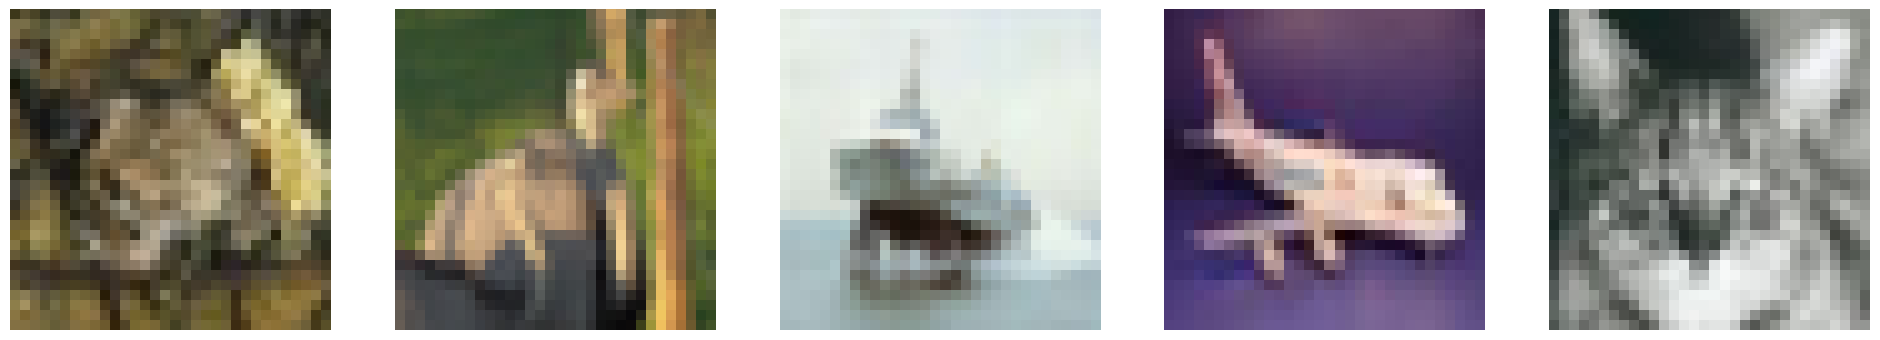

In [60]:
display_random_images(train_set,
                      n=5,
                      classes=class_names,
                      seed=None)

In [61]:
random.sample(range(len(train_set)), k=5)

[14067, 37719, 32222, 15452, 19690]

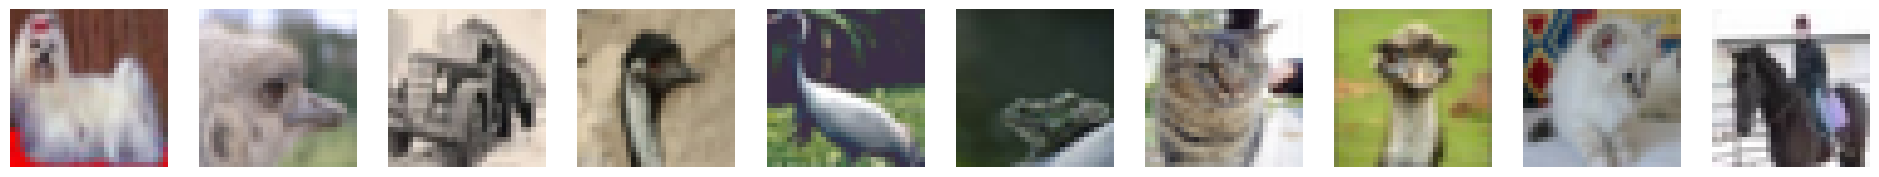

In [62]:
display_random_images(train_set,
                      n=10,
                      classes=class_names,
                      seed=None)

In [63]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(train_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)

In [64]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [65]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),      # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Random crop and resize
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [66]:
augmented_train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=augmentation_transform
)

augmented_train_dataloader = torch.utils.data.DataLoader(
    augmented_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

Files already downloaded and verified


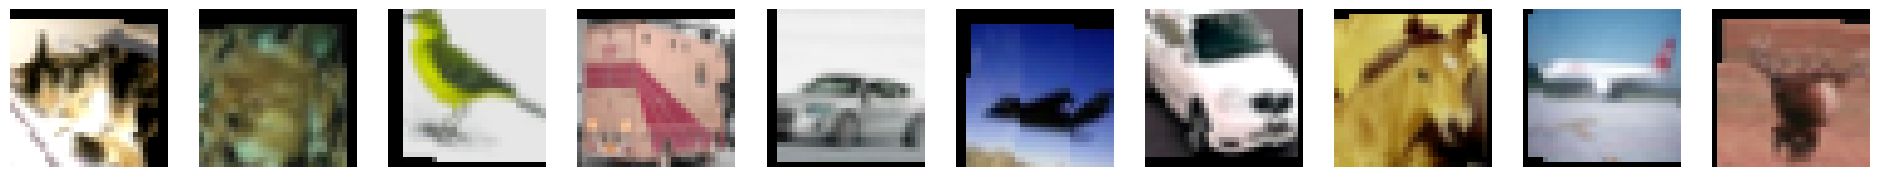

In [67]:
display_random_images(augmented_train_set,
                      n=10,
                      classes=class_names,
                      seed=None)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


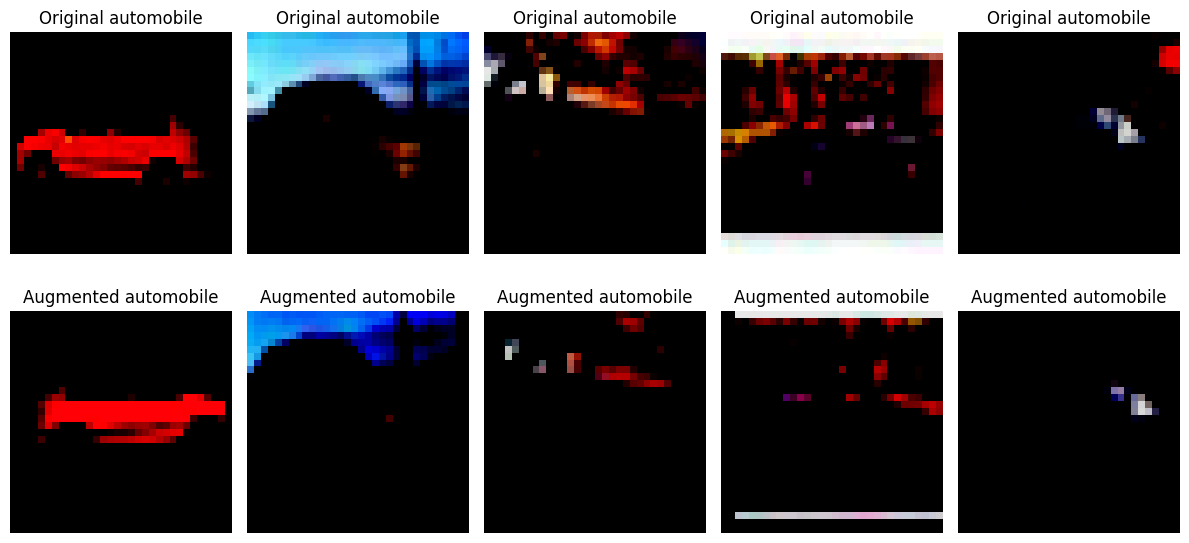

In [85]:
def display_original_and_augmented(dataset: torch.utils.data.Dataset,
                                   class_name: str,
                                   classes: List[str] = None,
                                   n: int = None,
                                   seed: int = None):
    if n is None:
        n = 5

    if seed:
        torch.manual_seed(seed)

    class_idx = class_to_idx[class_name]
    class_samples = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    random_original_samples = random.sample(class_samples, k=n)

    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ])


    plt.figure(figsize=(12, 6))

    for index, original_sample in enumerate(random_original_samples):
        original_image, _ = dataset[original_sample]
        augmented_image = augmentation_transform(original_image)


        # Apply ToTensor and Normalize to both original and augmented images
        original_image = transforms.Compose([
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(original_image)

        augmented_image = transforms.Compose([
            augmentation_transform,
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(original_image)

        plt.subplot(2, n, index + 1)
        plt.imshow(original_image.permute(1, 2, 0))
        plt.title(f"Original {class_name}")
        plt.axis('off')

        plt.subplot(2, n, n + index + 1)
        plt.imshow(augmented_image.permute(1, 2, 0))
        plt.title(f"Augmented {class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
display_original_and_augmented(train_set, class_name='automobile', classes=class_names, n=5, seed=None)


In [116]:
import torch
from torch import nn

class Model_0(nn.Module):
  def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
     super(Model_0,self).__init__()

     self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU())
     self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
                  nn.ReLU(),
                  nn.AvgPool2d(kernel_size=3))
     self.classifier = nn.Sequential(
     nn.Flatten(),
     nn.Linear(in_features=hidden_units*10*10,
              out_features=output_shape))
  def forward(self,x):
    x = self.conv_layer_1(x)
    #print(f"Shape after conv layer 1: {x.shape}")
    x = self.conv_layer_2(x)
    #print(f"Shape after conv layer 2: {x.shape}")
    x = self.classifier(x)
    #print(f"Shape after classifier {x.shape}")
    return x


In [101]:
model=Model_0(input_shape=3,
              hidden_units=10,
              output_shape=len(class_names))

In [102]:
rand_image = torch.randn(size=(3,32,32))
rand_image.shape

torch.Size([3, 32, 32])

In [103]:
model(rand_image.unsqueeze(0))

Shape after conv layer 1: torch.Size([1, 10, 32, 32])
Shape after conv layer 2: torch.Size([1, 10, 10, 10])
Shape after classifier torch.Size([1, 10])


tensor([[-0.0546, -0.0153, -0.0349, -0.0382,  0.0511, -0.0179, -0.0101, -0.0007,
         -0.0254,  0.0764]], grad_fn=<AddmmBackward0>)

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [106]:
!pip install tqdm

In [107]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [118]:
import tqdm as tqdm
epochs = 50
from timeit import default_timer as timer
train_time_start_model_0 = timer()
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for batch_idx, (inputs, labels) in enumerate(train_dataloader):
      inputs, labels = inputs, labels

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_loss = running_loss / len(train_dataloader)
  train_acc = 100 * correct / total

  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs, labels
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  test_loss /= len(test_dataloader)
  test_acc = 100 * correct / total

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv layer 2: torch.Size([32, 10, 10, 10])
Shape after classifier torch.Size([32, 10])
Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv layer 2: torch.Size([32, 10, 10, 10])
Shape after classifier torch.Size([32, 10])
Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv layer 2: torch.Size([32, 10, 10, 10])
Shape after classifier torch.Size([32, 10])
Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv layer 2: torch.Size([32, 10, 10, 10])
Shape after classifier torch.Size([32, 10])
Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv layer 2: torch.Size([32, 10, 10, 10])
Shape after classifier torch.Size([32, 10])
Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv layer 2: torch.Size([32, 10, 10, 10])
Shape after classifier torch.Size([32, 10])
Shape after conv layer 1: torch.Size([32, 10, 32, 32])
Shape after conv laye

KeyboardInterrupt: ignored